Demonstrating Viterbi decoding using standard educational trellis notation
Received sequence: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]


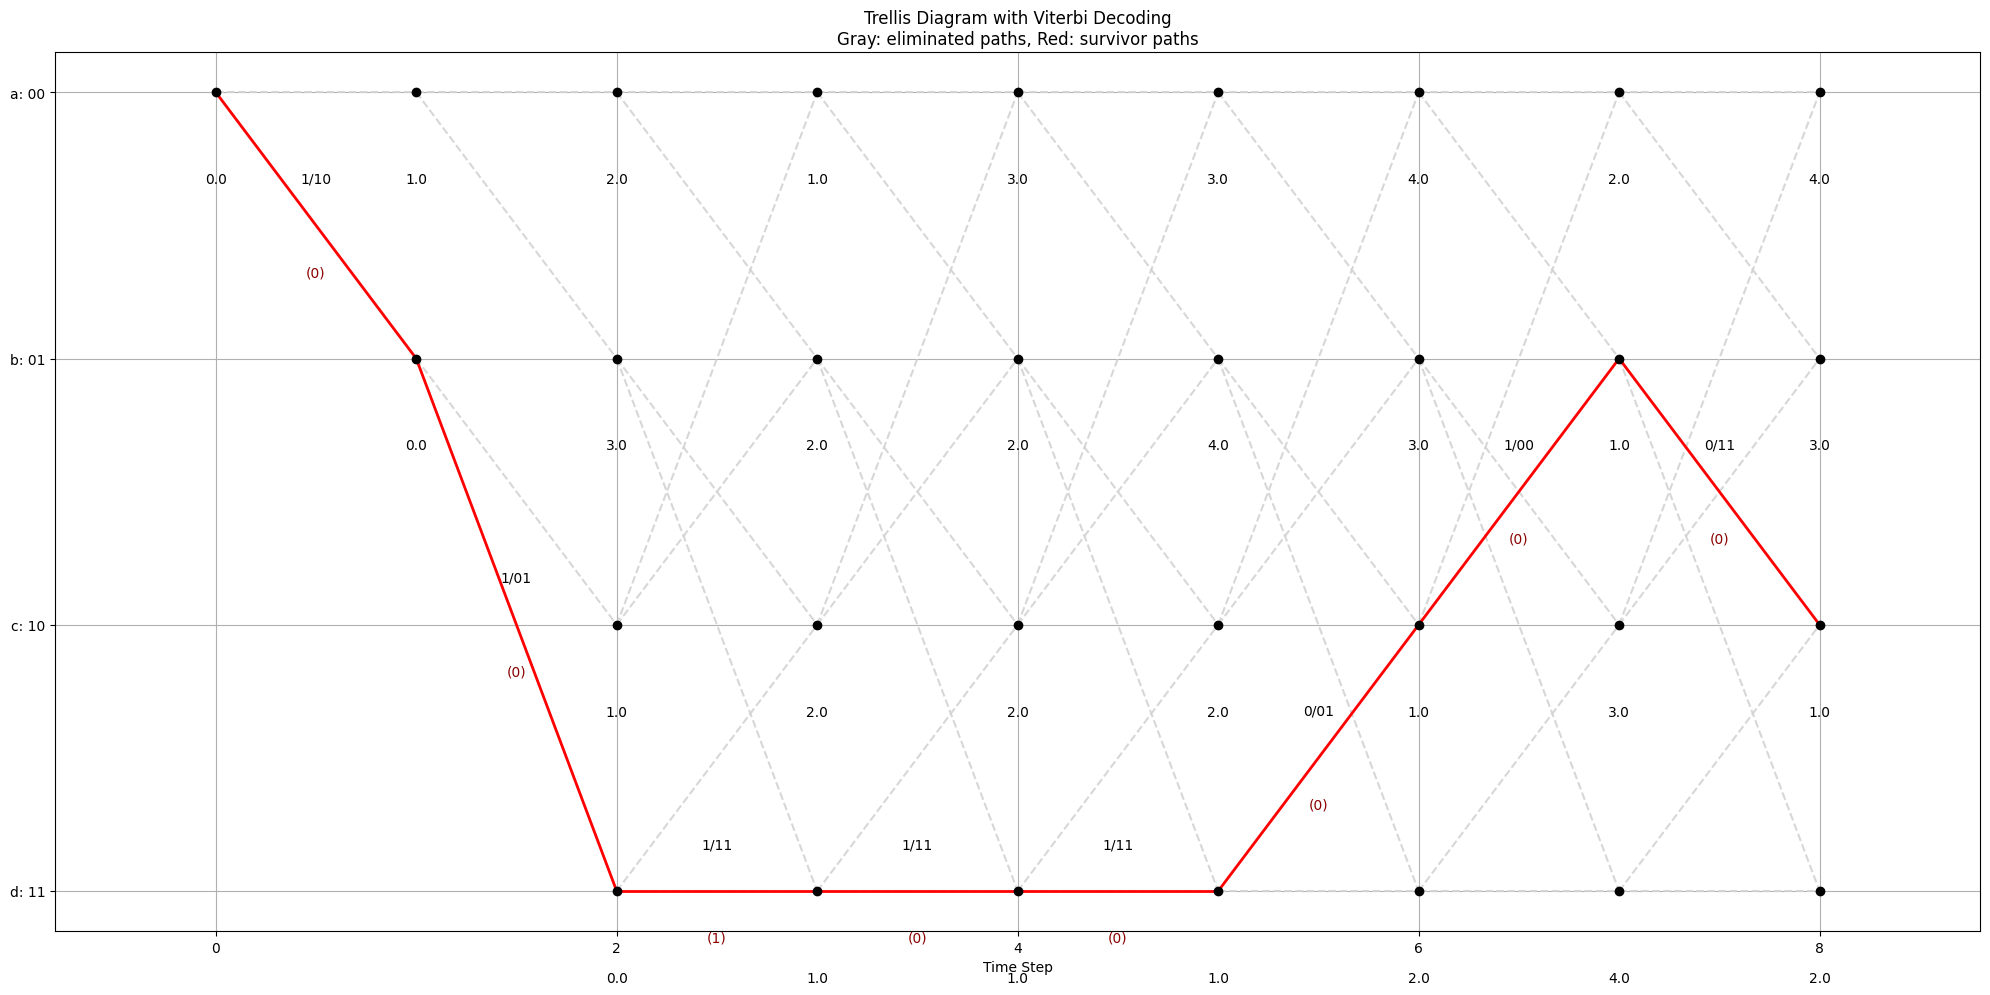


Decoded sequence: [1, 1, 1, 1, 1, 0, 1, 0]

Note:
- States are labeled a(00), b(01), c(10), d(11) as in standard notation
- Branch labels show input/output bits
- Red paths show the survivor paths
- Numbers in parentheses show branch metrics
- Numbers below states show accumulated metrics


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple

@dataclass
class TrellisState:
    """Class to store state information at each stage of the trellis."""
    accumulated_metric: float
    survivor_path: List[str]  # Store complete state sequence
    branch_metric: float = 0.0

class EducationalTrellisDecoder:
    def __init__(self):
        """Initialize decoder with standard state labeling (a, b, c, d)."""
        self.states = {'a': '00', 'b': '01', 'c': '10', 'd': '11'}
        self.state_transitions = self._generate_state_transitions()

    def _generate_state_transitions(self) -> Dict:
        """Generate state transitions and outputs matching the standard diagram."""
        transitions = {
            'a': [  # State 00
                {'input': 0, 'next_state': 'a', 'output': (0, 0)},  # Input 0
                {'input': 1, 'next_state': 'b', 'output': (1, 0)}   # Input 1
            ],
            'b': [  # State 01
                {'input': 0, 'next_state': 'c', 'output': (1, 1)},
                {'input': 1, 'next_state': 'd', 'output': (0, 1)}
            ],
            'c': [  # State 10
                {'input': 0, 'next_state': 'a', 'output': (1, 0)},
                {'input': 1, 'next_state': 'b', 'output': (0, 0)}
            ],
            'd': [  # State 11
                {'input': 0, 'next_state': 'c', 'output': (0, 1)},
                {'input': 1, 'next_state': 'd', 'output': (1, 1)}
            ]
        }
        return transitions

    def hamming_distance(self, received: Tuple[int, int], expected: Tuple[int, int]) -> int:
        """Calculate Hamming distance between received and expected bit pairs."""
        return sum(r != e for r, e in zip(received, expected))

    def decode(self, received_sequence: List[int], visualize: bool = True) -> List[int]:
        """Implement Viterbi decoding using standard state notation."""
        num_steps = len(received_sequence) // 2
        trellis = []

        # Initialize trellis
        initial_states = {}
        for state in self.states.keys():
            initial_states[state] = TrellisState(
                float('inf') if state != 'a' else 0.0,
                [state] if state == 'a' else []
            )
        trellis.append(initial_states)

        # Forward pass through trellis
        for t in range(num_steps):
            current_states = {state: TrellisState(float('inf'), [])
                            for state in self.states.keys()}
            received_pair = tuple(received_sequence[2*t:2*t+2])

            for current_state in self.states.keys():
                if trellis[t][current_state].accumulated_metric == float('inf'):
                    continue

                for transition in self.state_transitions[current_state]:
                    next_state = transition['next_state']
                    output = transition['output']

                    branch_metric = self.hamming_distance(received_pair, output)
                    path_metric = trellis[t][current_state].accumulated_metric + branch_metric

                    if path_metric < current_states[next_state].accumulated_metric:
                        current_states[next_state] = TrellisState(
                            path_metric,
                            trellis[t][current_state].survivor_path + [next_state],
                            branch_metric
                        )

            trellis.append(current_states)

        # Find best path
        final_state = min(trellis[-1].items(), key=lambda x: x[1].accumulated_metric)[0]
        best_path = trellis[-1][final_state].survivor_path

        if visualize:
            self._visualize_trellis(trellis, received_sequence, best_path)

        # Convert state sequence to input bits
        decoded_sequence = []
        for i in range(len(best_path)-1):
            current_state = best_path[i]
            next_state = best_path[i+1]
            # Find input bit that caused this transition
            for trans in self.state_transitions[current_state]:
                if trans['next_state'] == next_state:
                    decoded_sequence.append(trans['input'])
                    break

        return decoded_sequence

    def _visualize_trellis(self, trellis: List[Dict], received_sequence: List[int], best_path: List[str]):
        """Create enhanced visualization with clear paths and spacing."""
        plt.figure(figsize=(20, 10))
        state_positions = {'a': 3, 'b': 2, 'c': 1, 'd': 0}

        # Plot all possible transitions in light gray
        num_steps = len(trellis)
        for t in range(num_steps - 1):
            for current_state in self.states.keys():
                if trellis[t][current_state].accumulated_metric == float('inf'):
                    continue

                for transition in self.state_transitions[current_state]:
                    next_state = transition['next_state']
                    plt.plot([t, t+1],
                           [state_positions[current_state],
                            state_positions[next_state]],
                           color='lightgray', linestyle='--', alpha=0.9,
                           linewidth=1.5)

        # Plot survivor paths in red
        for t in range(num_steps - 1):
            current_state = best_path[t]
            next_state = best_path[t+1]

            # Find the transition that was used
            for transition in self.state_transitions[current_state]:
                if transition['next_state'] == next_state:
                    plt.plot([t, t+1],
                           [state_positions[current_state],
                            state_positions[next_state]],
                           'r-', linewidth=2)

                    # Add labels with spacing
                    mid_x = (t + t + 1) / 2
                    mid_y = (state_positions[current_state] +
                           state_positions[next_state]) / 2

                    # Input/output label
                    plt.text(mid_x, mid_y + 0.15,
                           f"{transition['input']}/{transition['output'][0]}"
                           f"{transition['output'][1]}",
                           ha='center', va='bottom')

                    # Branch metric
                    plt.text(mid_x, mid_y - 0.15,
                           f"({trellis[t+1][next_state].branch_metric})",
                           ha='center', va='top', color='darkred')

        # Plot states and accumulated metrics
        for t in range(num_steps):
            for state in self.states.keys():
                if trellis[t][state].accumulated_metric != float('inf'):
                    plt.plot(t, state_positions[state], 'ko')
                    plt.text(t, state_positions[state] - 0.3,
                            f'{trellis[t][state].accumulated_metric:.1f}',
                            ha='center', va='top')

        # Add state labels
        plt.yticks(list(state_positions.values()),
                  [f"{state}: {self.states[state]}" for state in state_positions.keys()])

        # Improve layout and spacing
        plt.margins(x=0.1)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
        plt.grid(True)
        plt.xlabel('Time Step')
        plt.title('Trellis Diagram with Viterbi Decoding\n'
                 'Gray: eliminated paths, Red: survivor paths')
        plt.tight_layout()
        plt.show()

def demonstrate_educational_decoding():
    """Demonstrate the decoder with educational notation."""
    decoder = EducationalTrellisDecoder()
    # Example received sequence
    #received_sequence = [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
    received_sequence = [1,0,0,1,1,0,1,1,1,1,0,1,0,0,1,1]
    print("Demonstrating Viterbi decoding using standard educational trellis notation")
    print("=====================================================================")
    print(f"Received sequence: {received_sequence}")

    decoded_sequence = decoder.decode(received_sequence, visualize=True)

    print(f"\nDecoded sequence: {decoded_sequence}")
    print("\nNote:")
    print("- States are labeled a(00), b(01), c(10), d(11) as in standard notation")
    print("- Branch labels show input/output bits")
    print("- Red paths show the survivor paths")
    print("- Numbers in parentheses show branch metrics")
    print("- Numbers below states show accumulated metrics")

if __name__ == "__main__":
    demonstrate_educational_decoding()